In [1]:
import os
import pickle
import numpy as np
from infect import infect
from algos import *
from sbm import SBM
import matplotlib.pyplot as plt

#we need to optimize no of tests and stages

infection = 0.3
array = np.random.choice([0, 1], size=1028, p=[1 - infection, infection])

print(naive_testing(array)[0:2])
print(binary_splitting(array)[0:2])
print(diag_splitting(array))
print(Qtesting1(array))
print(Qtesting2(array))

(1028, 1)
(3122, 3122)
(1173, 9)
(1023, 1)
(1030, 2)


In [ ]:
def group_division_testing(s):
    num, stages = 0, 0
    if len(s) == 0: 
        return num, stages


    num_infected = sum(s)
    num+=1
    stages += 1

    if num_infected/len(s) < 0.05:
        bin_num, bin_stages = parallel_binary_splitting(s)
        num += bin_num
        stages += bin_stages
        return num, stages
    
    group_size = max(1, len(s) // 64)
    groups = [s[i:i + group_size] for i in range(0, len(s), group_size)]
    
    # Apply parallel binary splitting on each group
    for group in groups:
        if len(group) > 1:
            num_sub, stages_sub = Qtesting1_bin(group)
            num += num_sub
            stages = max(stages, stages_sub)
    
    return num, stages

# Example usage:
infection_probability = 0.01
array = np.random.choice([0, 1], size=256, p=[1 - infection_probability, infection_probability])
tests, stages = group_division_testing(array)
print("group_division_testing:", tests, stages)

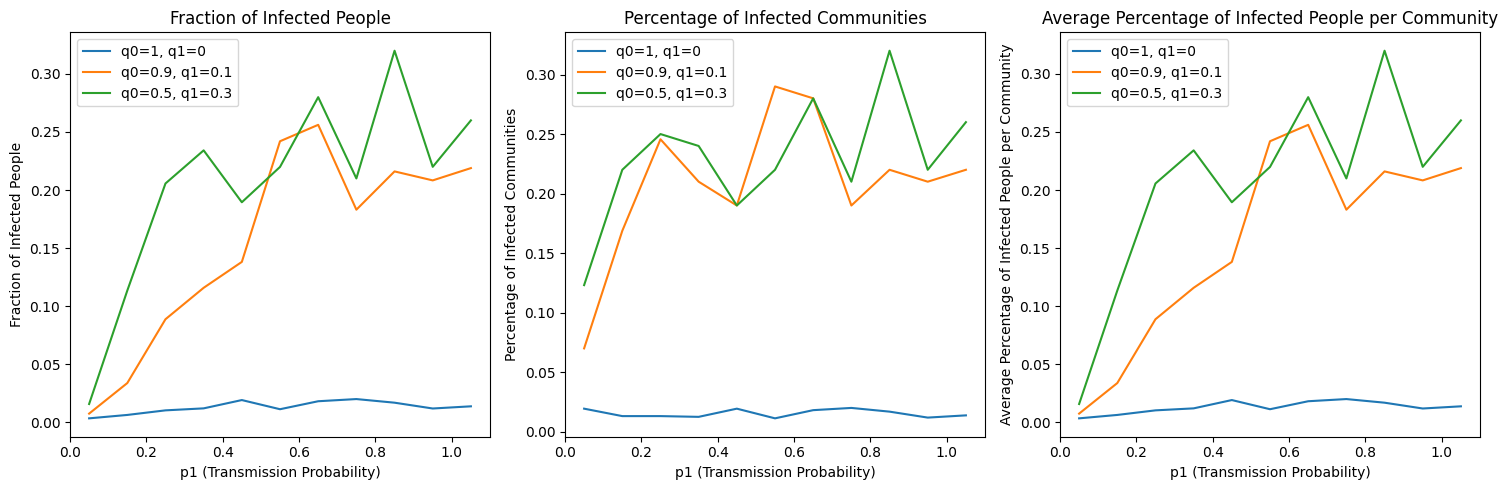

In [17]:
# SBM STUFF: FAMILY AVERAGES, ETC ACROSS 100
################################## Table 2
# Simulation parameters
N = 256
M = 16
q_values = [(1, 0), (0.9, 0.1), (0.5, 0.3)]
p0 = 0.001
p1_values = np.arange(0.05, 1.1, 0.1)
time_steps = 2
num_simulations = 100

# Data structures to hold results
fraction_infected_people = {q: [] for q in q_values}
percentage_infected_communities = {q: [] for q in q_values}
average_infected_people_per_community = {q: [] for q in q_values}

# Run simulations
for q0, q1 in q_values:
    for p1 in p1_values:
        total_fraction_infected = 0
        total_percentage_infected_communities = 0
        total_average_infected_per_community = 0

        for _ in range(num_simulations):
            G = SBM(N, M, q0, q1)
            final_infections = infect(G, p0, p1, time_steps)

            fraction_infected = np.sum(final_infections) / N
            total_fraction_infected += fraction_infected

            infected_communities = 0
            infected_counts_per_community = []
            communities = np.array_split(np.arange(N), M)

            for community in communities:
                infected_count = np.sum(final_infections[community])
                infected_counts_per_community.append(infected_count / len(community))
                if infected_count > 0:
                    infected_communities += 1

            percentage_infected_communities_sim = infected_communities / M
            total_percentage_infected_communities += percentage_infected_communities_sim

            average_infected_per_community = np.mean(infected_counts_per_community)
            total_average_infected_per_community += average_infected_per_community

        fraction_infected_people[(q0, q1)].append(total_fraction_infected / num_simulations)
        percentage_infected_communities[(q0, q1)].append(total_percentage_infected_communities / num_simulations)
        average_infected_people_per_community[(q0, q1)].append(total_average_infected_per_community / num_simulations)

# Plotting results
plt.figure(figsize=(15, 5))

# Fraction of infected people
plt.subplot(1, 3, 1)
for q in q_values:
    plt.plot(p1_values, fraction_infected_people[q], label=f'q0={q[0]}, q1={q[1]}')
plt.xlabel('p1 (Transmission Probability)')
plt.ylabel('Fraction of Infected People')
plt.title('Fraction of Infected People')
plt.legend()

# Percentage of infected communities
plt.subplot(1, 3, 2)
for q in q_values:
    plt.plot(p1_values, percentage_infected_communities[q], label=f'q0={q[0]}, q1={q[1]}')
plt.xlabel('p1 (Transmission Probability)')
plt.ylabel('Percentage of Infected Communities')
plt.title('Percentage of Infected Communities')
plt.legend()

# Average percentage of infected people per community
plt.subplot(1, 3, 3)
for q in q_values:
    plt.plot(p1_values, average_infected_people_per_community[q], label=f'q0={q[0]}, q1={q[1]}')
plt.xlabel('p1 (Transmission Probability)')
plt.ylabel('Average Percentage of Infected People per Community')
plt.title('Average Percentage of Infected People per Community')
plt.legend()

plt.tight_layout()
plt.show()



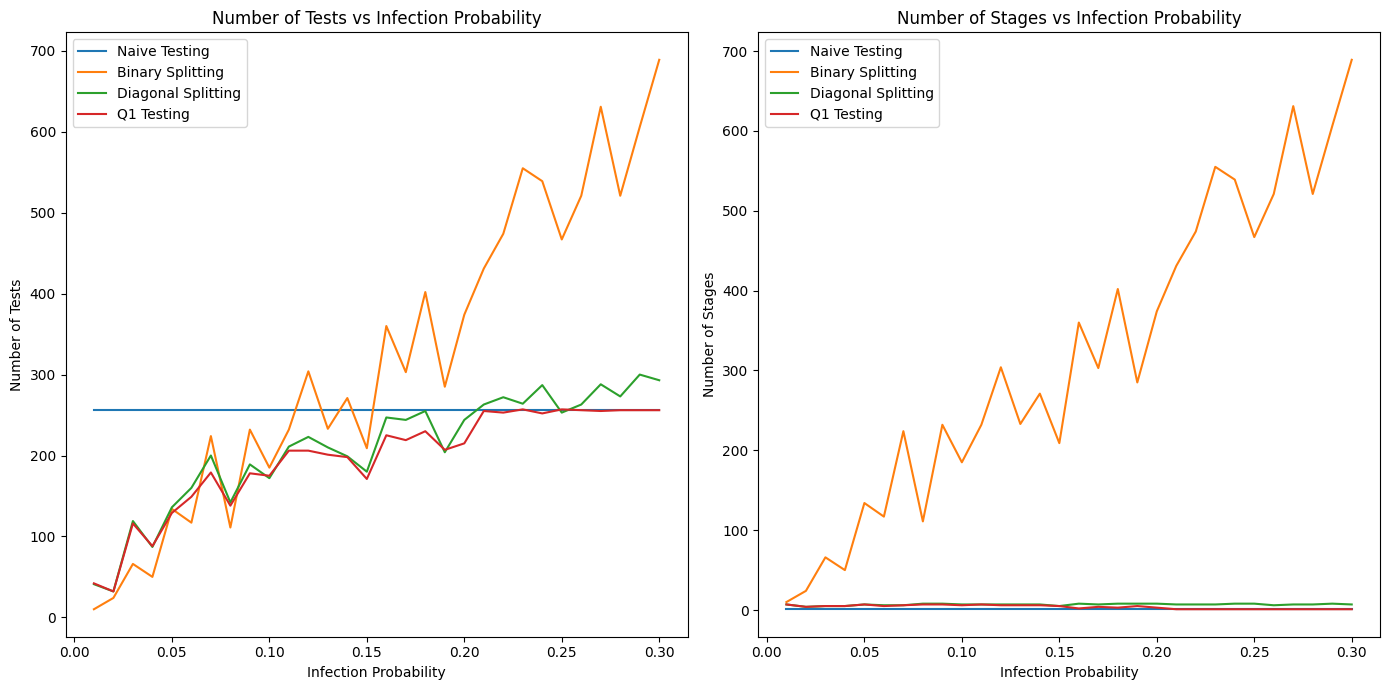

In [2]:
#performance test of qtesting1, diag_splitting, binary_splitting, naive_testing
np.random.seed(50)

# Functions (assuming they are already defined in your code)
# naive_testing, binary_splitting, diag_splitting, Qtesting1

# Initialize lists to store results
infection_probs = np.arange(0.01, 0.31, 0.01)
naive_tests_list = []
binary_tests_list = []
diag_tests_list = []
Q1_tests_list = []

naive_stages_list = []
binary_stages_list = []
diag_stages_list = []
Q1_stages_list = []

# Iterate over infection probabilities
for p in infection_probs:
    array = np.random.choice([0, 1], size=256, p=[1 - p, p])
    
    naive_tests, naive_stages = naive_testing(array)[0:2]
    binary_tests, binary_stages = binary_splitting(array)[0:2]
    diag_tests, diag_stages = diag_splitting(array)
    Q1_tests, Q1_stages = Qtesting1(array)
    
    naive_tests_list.append(naive_tests)
    binary_tests_list.append(binary_tests)
    diag_tests_list.append(diag_tests)
    Q1_tests_list.append(Q1_tests)
    
    naive_stages_list.append(naive_stages)
    binary_stages_list.append(binary_stages)
    diag_stages_list.append(diag_stages)
    Q1_stages_list.append(Q1_stages)

# Plotting the number of tests
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(infection_probs, naive_tests_list, label='Naive Testing')
plt.plot(infection_probs, binary_tests_list, label='Binary Splitting')
plt.plot(infection_probs, diag_tests_list, label='Diagonal Splitting')
plt.plot(infection_probs, Q1_tests_list, label='Q1 Testing')
plt.xlabel('Infection Probability')
plt.ylabel('Number of Tests')
plt.title('Number of Tests vs Infection Probability')
plt.legend()

# Plotting the number of stages
plt.subplot(1, 2, 2)
plt.plot(infection_probs, naive_stages_list, label='Naive Testing')
plt.plot(infection_probs, binary_stages_list, label='Binary Splitting')
plt.plot(infection_probs, diag_stages_list, label='Diagonal Splitting')
plt.plot(infection_probs, Q1_stages_list, label='Q1 Testing')
plt.xlabel('Infection Probability')
plt.ylabel('Number of Stages')
plt.title('Number of Stages vs Infection Probability')
plt.legend()

plt.tight_layout()
plt.show()

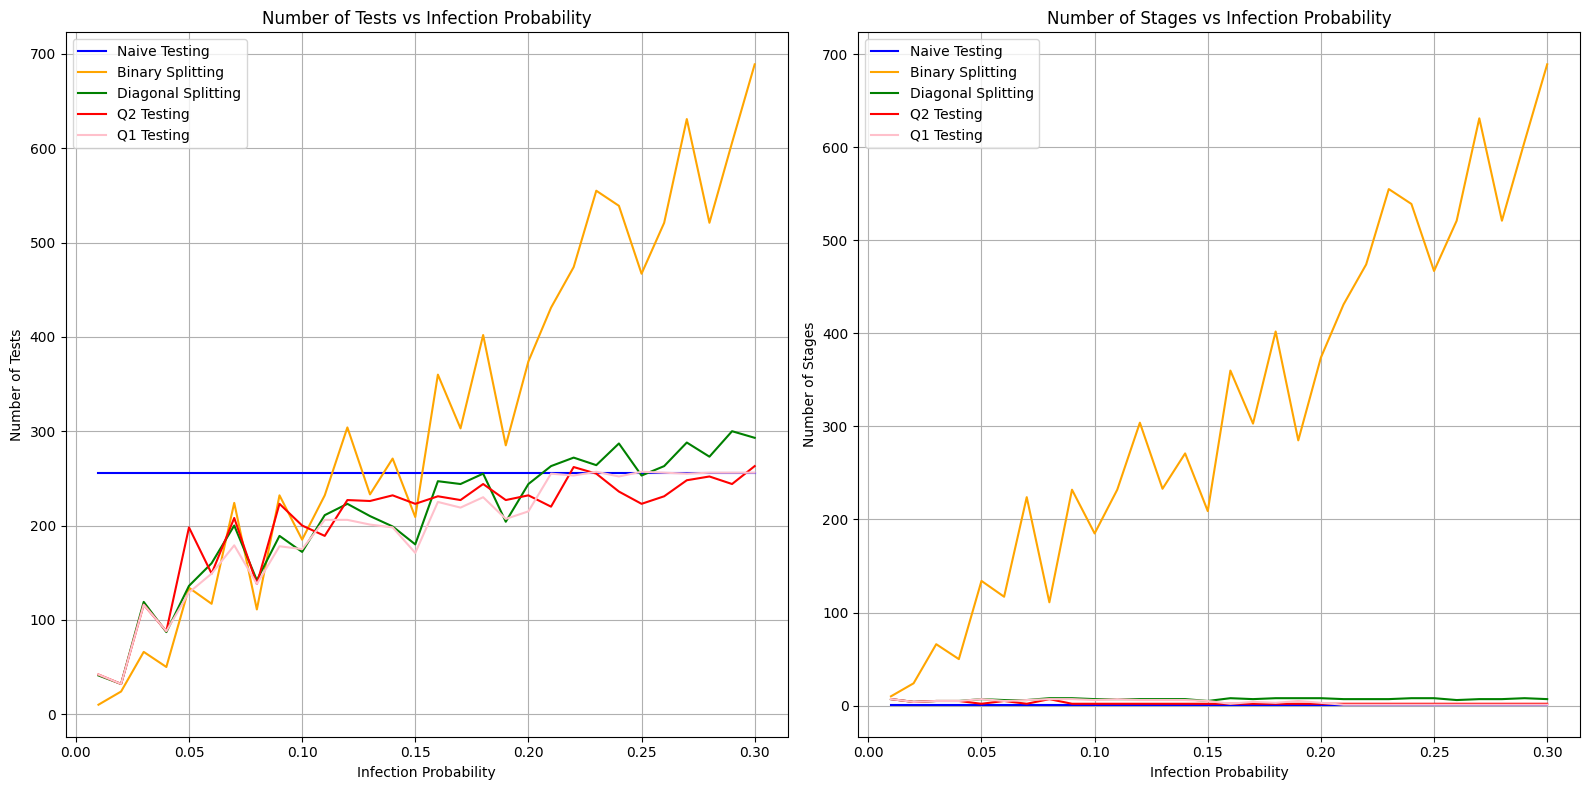

In [3]:
#FOR QTESTING2
#performance test of qtesting2, diag_splitting, binary_splitting, naive_testing
np.random.seed(50)

# Functions (assuming they are already defined in your code)
# naive_testing, binary_splitting, diag_splitting, Qtesting1

# Initialize lists to store results
infection_probabilities = np.arange(0.01, 0.31, 0.01)
num_tests_naive = []
num_tests_binary = []
num_tests_diag = []
num_tests_q1 = []
num_tests_q2 = []
stages_naive = []
stages_binary = []
stages_diag = []
stages_q2 = []
stages_q1 = []


for p in infection_probabilities:
    array = np.random.choice([0, 1], size=256, p=[1 - p, p])
    num, stages, _ = naive_testing(array)
    num_tests_naive.append(num)
    stages_naive.append(stages)

    num, stages, _ = binary_splitting(array)
    num_tests_binary.append(num)
    stages_binary.append(stages)

    num, stages = diag_splitting(array)
    num_tests_diag.append(num)
    stages_diag.append(stages)

    num, stages = Qtesting2(array)
    num_tests_q2.append(num)
    stages_q2.append(stages)

    num, stages = Qtesting1(array)
    num_tests_q1.append(num)
    stages_q1.append(stages)
    
plt.figure(figsize=(16, 8))

# Plot Number of Tests
plt.subplot(1, 2, 1)
plt.plot(infection_probabilities, num_tests_naive, label="Naive Testing", color='blue')
plt.plot(infection_probabilities, num_tests_binary, label="Binary Splitting", color='orange')
plt.plot(infection_probabilities, num_tests_diag, label="Diagonal Splitting", color='green')
plt.plot(infection_probabilities, num_tests_q2, label="Q2 Testing", color='red')
plt.plot(infection_probabilities, num_tests_q1, label="Q1 Testing", color='pink')

plt.xlabel("Infection Probability")
plt.ylabel("Number of Tests")
plt.title("Number of Tests vs Infection Probability")
plt.legend()
plt.grid(True)

# Plot Number of Stages
plt.subplot(1, 2, 2)
plt.plot(infection_probabilities, stages_naive, label="Naive Testing", color='blue')
plt.plot(infection_probabilities, stages_binary, label="Binary Splitting", color='orange')
plt.plot(infection_probabilities, stages_diag, label="Diagonal Splitting", color='green')
plt.plot(infection_probabilities, stages_q2, label="Q2 Testing", color='red')
plt.plot(infection_probabilities, stages_q1, label="Q1 Testing", color='pink')

plt.xlabel("Infection Probability")
plt.ylabel("Number of Stages")
plt.title("Number of Stages vs Infection Probability")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

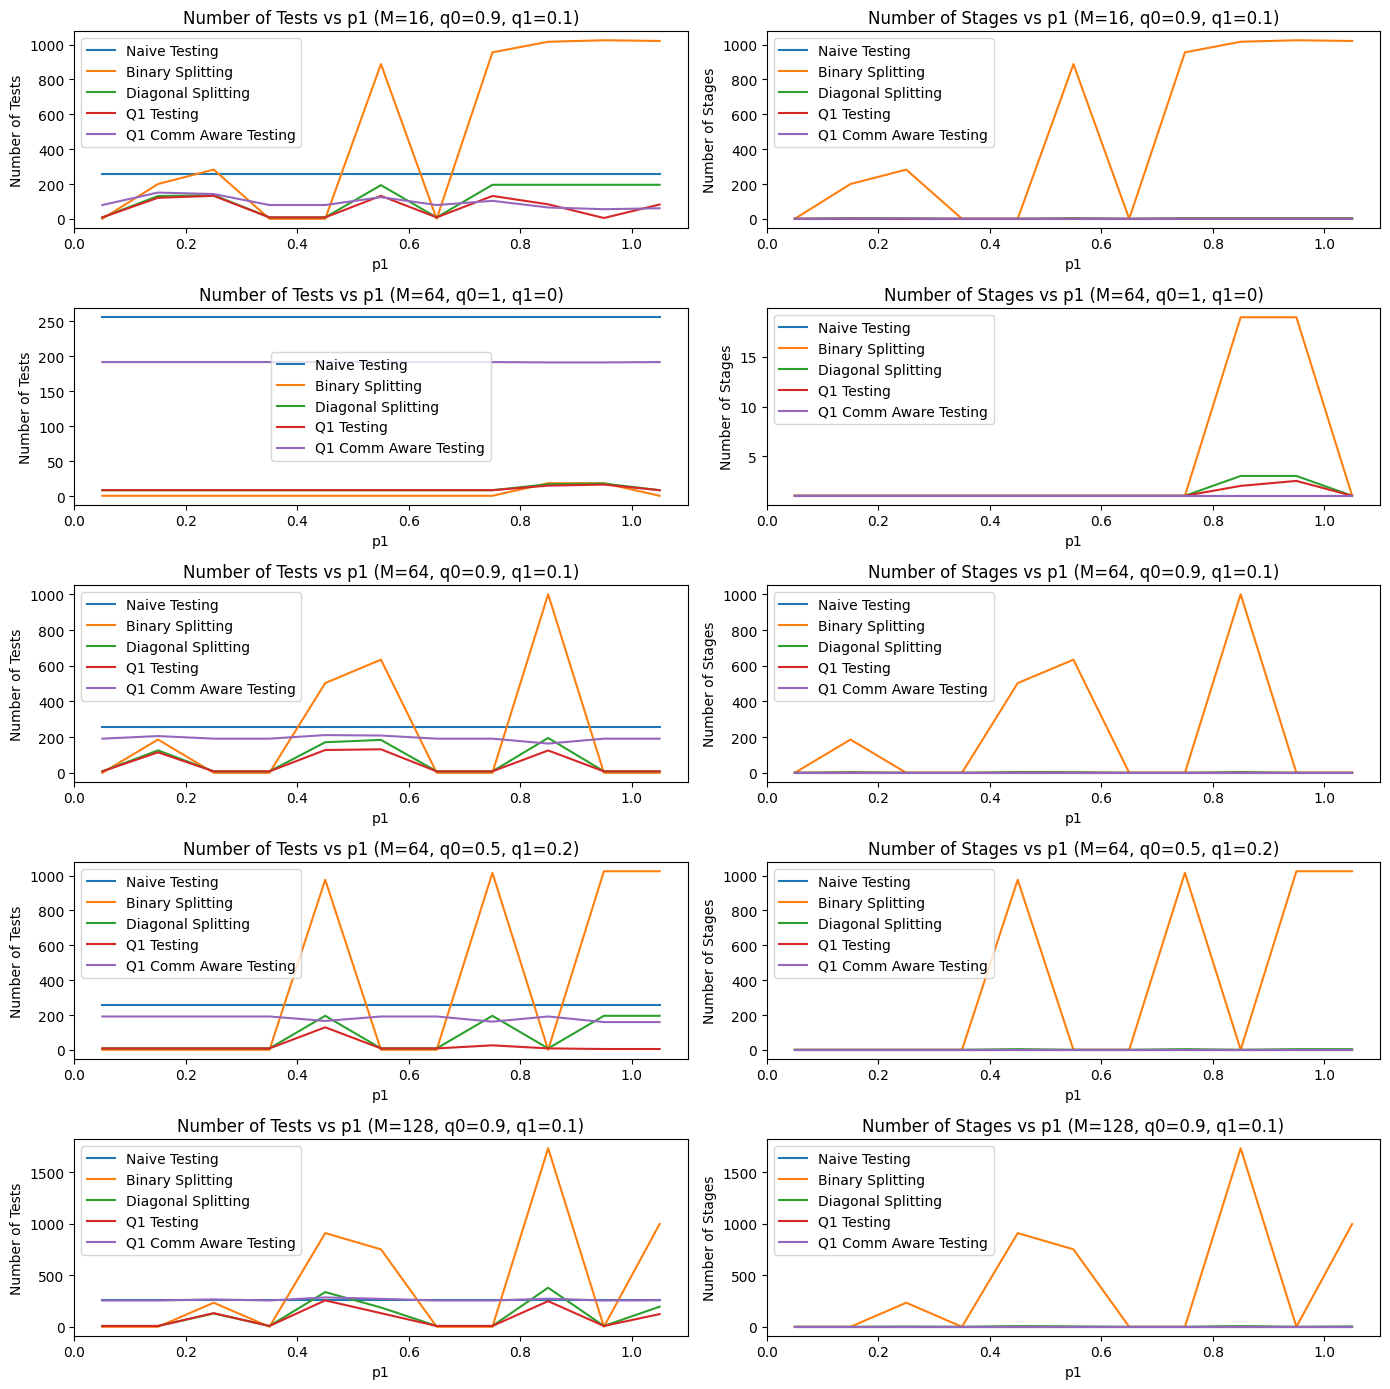

In [4]:

##################################
# this is when changing p1
##################################

# Set the parameters from Table 3
N = 256
parameter_sets = [
    (16, 0.9, 0.1, 0.001, 2),
    (64, 1, 0, 0.001, 2),
    (64, 0.9, 0.1, 0.001, 2),
    (64, 0.5, 0.2, 0.001, 2),
    (128, 0.9, 0.1, 0.001, 2)
]

# Initialize lists to store results
p1_values = np.arange(0.05, 1.1, 0.1)
results = {ps: {"naive": [], "binary": [], "diag": [], "Q1": [], "Q1Comm": []} for ps in parameter_sets}

# Run simulations
num_simulations = 2
for (M, q0, q1, p0, time_steps) in parameter_sets:
    for p1 in p1_values:
        naive_tests_total, naive_stages_total = 0, 0
        binary_tests_total, binary_stages_total = 0, 0
        diag_tests_total, diag_stages_total = 0, 0
        Q1_tests_total, Q1_stages_total = 0, 0
        Q1Comm_tests_total, Q1Comm_stages_total = 0, 0

        for _ in range(num_simulations):
            G = SBM(N, M, q0, q1)
            communities = create_communities(N, M)
            infection_progression = infect(G, p0, p1, time_steps)
            final_state = infection_progression

            naive_tests, naive_stages = naive_testing(final_state)[0:2]
            binary_tests, binary_stages = binary_splitting(final_state)[0:2]
            diag_tests, diag_stages = diag_splitting(final_state)
            Q1_tests, Q1_stages = Qtesting1(final_state)
            Q1Comm_tests, Q1Comm_stages = Qtesting1_comm_aware(final_state, communities)

            naive_tests_total += naive_tests
            naive_stages_total += naive_stages
            binary_tests_total += binary_tests
            binary_stages_total += binary_stages
            diag_tests_total += diag_tests
            diag_stages_total += diag_stages
            Q1_tests_total += Q1_tests
            Q1_stages_total += Q1_stages
            Q1Comm_tests_total += Q1Comm_tests
            Q1Comm_stages_total += Q1Comm_stages

        results[(M, q0, q1, p0, time_steps)]["naive"].append((naive_tests_total / num_simulations, naive_stages_total / num_simulations))
        results[(M, q0, q1, p0, time_steps)]["binary"].append((binary_tests_total / num_simulations, binary_stages_total / num_simulations))
        results[(M, q0, q1, p0, time_steps)]["diag"].append((diag_tests_total / num_simulations, diag_stages_total / num_simulations))
        results[(M, q0, q1, p0, time_steps)]["Q1"].append((Q1_tests_total / num_simulations, Q1_stages_total / num_simulations))
        results[(M, q0, q1, p0, time_steps)]["Q1Comm"].append((Q1Comm_tests_total / num_simulations, Q1Comm_stages_total / num_simulations))

# Plotting the results
plt.figure(figsize=(14, 14))

for idx, (M, q0, q1, p0, time_steps) in enumerate(parameter_sets):
    plt.subplot(len(parameter_sets), 2, 2*idx + 1)
    plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["naive"]], label='Naive Testing')
    plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["binary"]], label='Binary Splitting')
    plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["diag"]], label='Diagonal Splitting')
    plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["Q1"]], label='Q1 Testing')
    plt.plot(p1_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["Q1Comm"]], label='Q1 Comm Aware Testing')
    plt.xlabel('p1')
    plt.ylabel('Number of Tests')
    plt.title(f'Number of Tests vs p1 (M={M}, q0={q0}, q1={q1})')
    plt.legend()

    plt.subplot(len(parameter_sets), 2, 2*idx + 2)
    plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["naive"]], label='Naive Testing')
    plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["binary"]], label='Binary Splitting')
    plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["diag"]], label='Diagonal Splitting')
    plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["Q1"]], label='Q1 Testing')
    plt.plot(p1_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["Q1Comm"]], label='Q1 Comm Aware Testing')
    plt.xlabel('p1')
    plt.ylabel('Number of Stages')
    plt.title(f'Number of Stages vs p1 (M={M}, q0={q0}, q1={q1})')
    plt.legend()

plt.tight_layout()
plt.show()

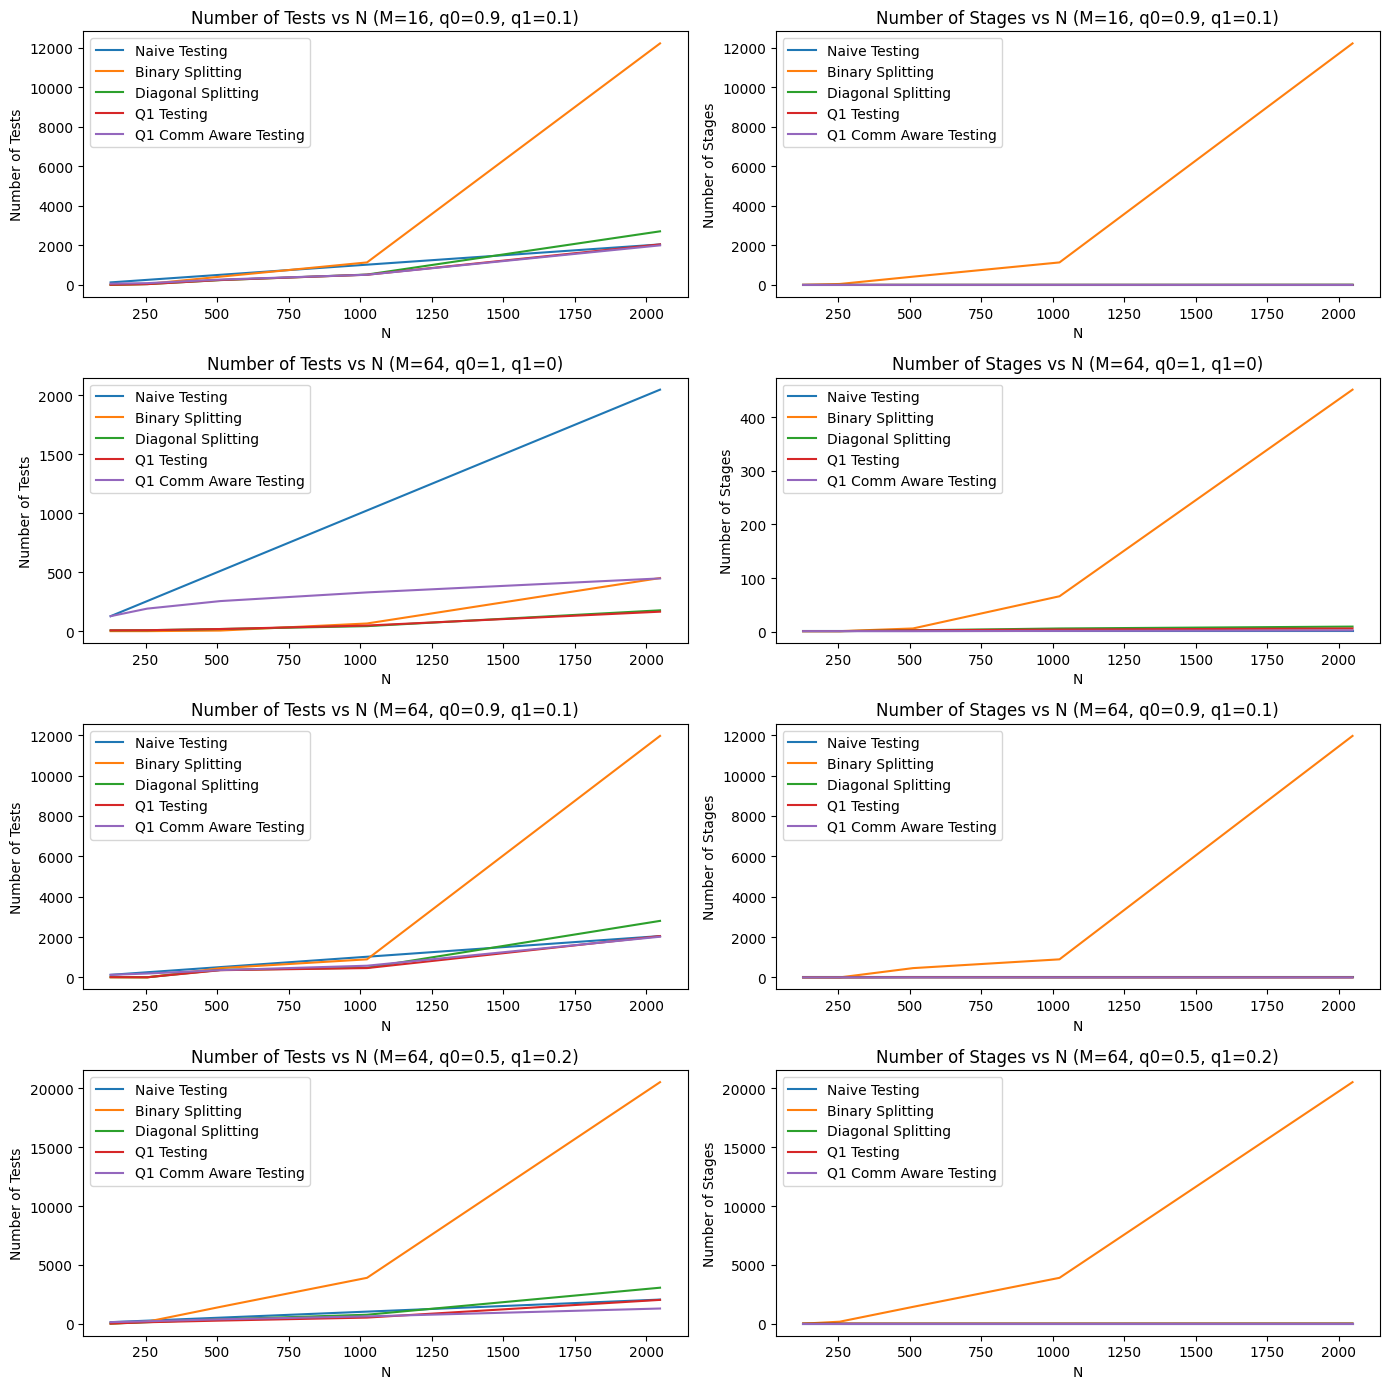

In [5]:

##################################
# this is when changing N
##################################

# Set the parameters from Table 3
p1 = 0.1
parameter_sets = [
    (16, 0.9, 0.1, 0.001, 2),
    (64, 1, 0, 0.001, 2),
    (64, 0.9, 0.1, 0.001, 2),
    (64, 0.5, 0.2, 0.001, 2),
]

# Initialize lists to store results
N_values = [128, 256, 512, 1024, 2048]
results = {ps: {"naive": [], "binary": [], "diag": [], "Q1": [], "Q1Comm": []} for ps in parameter_sets}

# Run simulations
num_simulations = 2
for (M, q0, q1, p0, time_steps) in parameter_sets:
    for N in N_values:
        naive_tests_total, naive_stages_total = 0, 0
        binary_tests_total, binary_stages_total = 0, 0
        diag_tests_total, diag_stages_total = 0, 0
        Q1_tests_total, Q1_stages_total = 0, 0
        Q1Comm_tests_total, Q1Comm_stages_total = 0, 0

        for _ in range(num_simulations):
            G = SBM(N, M, q0, q1)
            communities = create_communities(N, M)
            infection_progression = infect(G, p0, p1, time_steps)
            final_state = infection_progression

            naive_tests, naive_stages = naive_testing(final_state)[0:2]
            binary_tests, binary_stages = binary_splitting(final_state)[0:2]
            diag_tests, diag_stages = diag_splitting(final_state)
            Q1_tests, Q1_stages = Qtesting1(final_state)
            Q1Comm_tests, Q1Comm_stages = Qtesting1_comm_aware(final_state, communities)

            naive_tests_total += naive_tests
            naive_stages_total += naive_stages
            binary_tests_total += binary_tests
            binary_stages_total += binary_stages
            diag_tests_total += diag_tests
            diag_stages_total += diag_stages
            Q1_tests_total += Q1_tests
            Q1_stages_total += Q1_stages
            Q1Comm_tests_total += Q1Comm_tests
            Q1Comm_stages_total += Q1Comm_stages

        results[(M, q0, q1, p0, time_steps)]["naive"].append((naive_tests_total / num_simulations, naive_stages_total / num_simulations))
        results[(M, q0, q1, p0, time_steps)]["binary"].append((binary_tests_total / num_simulations, binary_stages_total / num_simulations))
        results[(M, q0, q1, p0, time_steps)]["diag"].append((diag_tests_total / num_simulations, diag_stages_total / num_simulations))
        results[(M, q0, q1, p0, time_steps)]["Q1"].append((Q1_tests_total / num_simulations, Q1_stages_total / num_simulations))
        results[(M, q0, q1, p0, time_steps)]["Q1Comm"].append((Q1Comm_tests_total / num_simulations, Q1Comm_stages_total / num_simulations))

# Plotting the results
plt.figure(figsize=(14, 14))

for idx, (M, q0, q1, p0, time_steps) in enumerate(parameter_sets):
    plt.subplot(len(parameter_sets), 2, 2*idx + 1)
    plt.plot(N_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["naive"]], label='Naive Testing')
    plt.plot(N_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["binary"]], label='Binary Splitting')
    plt.plot(N_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["diag"]], label='Diagonal Splitting')
    plt.plot(N_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["Q1"]], label='Q1 Testing')
    plt.plot(N_values, [x[0] for x in results[(M, q0, q1, p0, time_steps)]["Q1Comm"]], label='Q1 Comm Aware Testing')
    plt.xlabel('N')
    plt.ylabel('Number of Tests')
    plt.title(f'Number of Tests vs N (M={M}, q0={q0}, q1={q1})')
    plt.legend()

    plt.subplot(len(parameter_sets), 2, 2*idx + 2)
    plt.plot(N_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["naive"]], label='Naive Testing')
    plt.plot(N_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["binary"]], label='Binary Splitting')
    plt.plot(N_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["diag"]], label='Diagonal Splitting')
    plt.plot(N_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["Q1"]], label='Q1 Testing')
    plt.plot(N_values, [x[1] for x in results[(M, q0, q1, p0, time_steps)]["Q1Comm"]], label='Q1 Comm Aware Testing')
    plt.xlabel('N')
    plt.ylabel('Number of Stages')
    plt.title(f'Number of Stages vs N (M={M}, q0={q0}, q1={q1})')
    plt.legend()

plt.tight_layout()
plt.show()

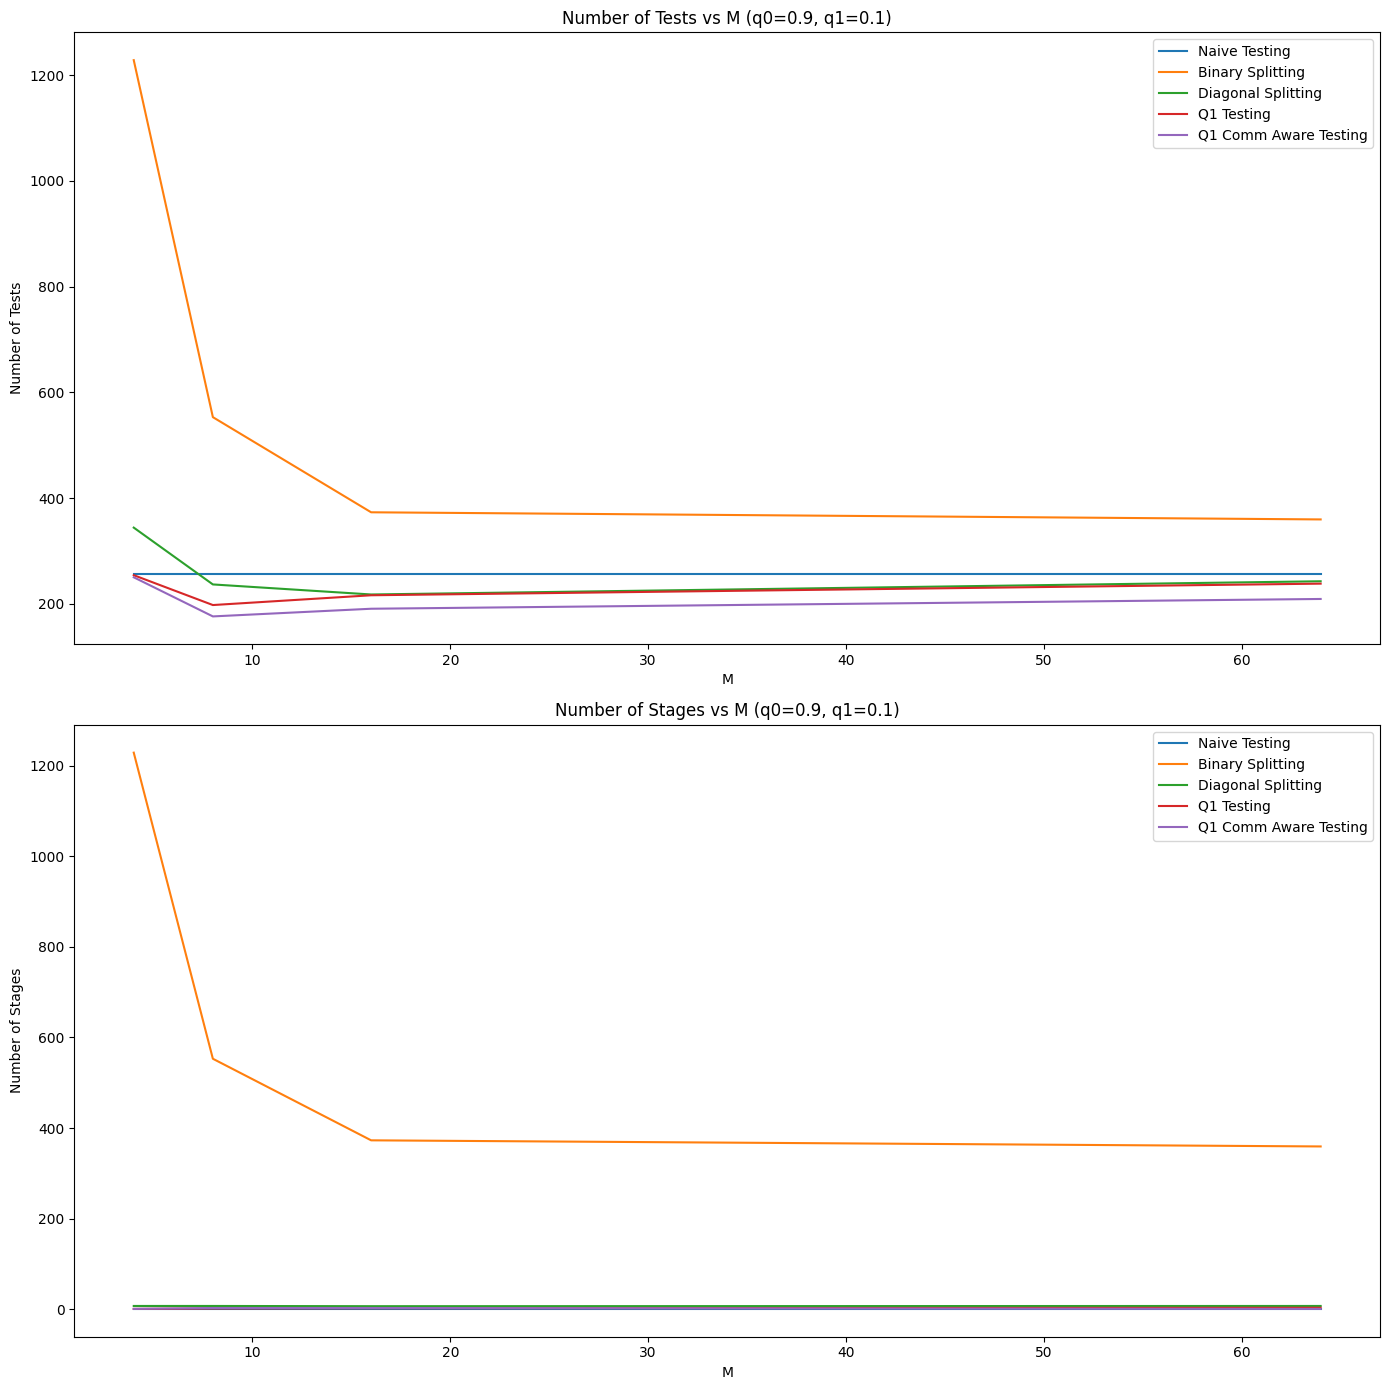

In [6]:

##################################
# this is when changing M
##################################

# Set the parameters
N = 256
p0 = 0.01
p1 = 0.1
q0 = 0.9
q1 = 0.1
time_steps = 2

# Initialize lists to store results
M_values = [4, 8, 16, 64]
results = {"naive": [], "binary": [], "diag": [], "Q1": [], "Q1Comm": []}

# Run simulations
num_simulations = 2
for M in M_values:
    naive_tests_total, naive_stages_total = 0, 0
    binary_tests_total, binary_stages_total = 0, 0
    diag_tests_total, diag_stages_total = 0, 0
    Q1_tests_total, Q1_stages_total = 0, 0
    Q1Comm_tests_total, Q1Comm_stages_total = 0, 0

    for _ in range(num_simulations):
        G = SBM(N, M, q0, q1)
        communities = create_communities(N, M)
        infection_progression = infect(G, p0, p1, time_steps)
        final_state = infection_progression

        naive_tests, naive_stages = naive_testing(final_state)[0:2]
        binary_tests, binary_stages = binary_splitting(final_state)[0:2]
        diag_tests, diag_stages = diag_splitting(final_state)
        Q1_tests, Q1_stages = Qtesting1(final_state)
        Q1Comm_tests, Q1Comm_stages = Qtesting1_comm_aware(final_state, communities)

        naive_tests_total += naive_tests
        naive_stages_total += naive_stages
        binary_tests_total += binary_tests
        binary_stages_total += binary_stages
        diag_tests_total += diag_tests
        diag_stages_total += diag_stages
        Q1_tests_total += Q1_tests
        Q1_stages_total += Q1_stages
        Q1Comm_tests_total += Q1Comm_tests
        Q1Comm_stages_total += Q1Comm_stages

    results["naive"].append((naive_tests_total / num_simulations, naive_stages_total / num_simulations))
    results["binary"].append((binary_tests_total / num_simulations, binary_stages_total / num_simulations))
    results["diag"].append((diag_tests_total / num_simulations, diag_stages_total / num_simulations))
    results["Q1"].append((Q1_tests_total / num_simulations, Q1_stages_total / num_simulations))
    results["Q1Comm"].append((Q1Comm_tests_total / num_simulations, Q1Comm_stages_total / num_simulations))

# Plotting the results
plt.figure(figsize=(14, 14))

plt.subplot(2, 1, 1)
plt.plot(M_values, [x[0] for x in results["naive"]], label='Naive Testing')
plt.plot(M_values, [x[0] for x in results["binary"]], label='Binary Splitting')
plt.plot(M_values, [x[0] for x in results["diag"]], label='Diagonal Splitting')
plt.plot(M_values, [x[0] for x in results["Q1"]], label='Q1 Testing')
plt.plot(M_values, [x[0] for x in results["Q1Comm"]], label='Q1 Comm Aware Testing')
plt.xlabel('M')
plt.ylabel('Number of Tests')
plt.title(f'Number of Tests vs M (q0={q0}, q1={q1})')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(M_values, [x[1] for x in results["naive"]], label='Naive Testing')
plt.plot(M_values, [x[1] for x in results["binary"]], label='Binary Splitting')
plt.plot(M_values, [x[1] for x in results["diag"]], label='Diagonal Splitting')
plt.plot(M_values, [x[1] for x in results["Q1"]], label='Q1 Testing')
plt.plot(M_values, [x[1] for x in results["Q1Comm"]], label='Q1 Comm Aware Testing')
plt.xlabel('M')
plt.ylabel('Number of Stages')
plt.title(f'Number of Stages vs M (q0={q0}, q1={q1})')
plt.legend()

plt.tight_layout()
plt.show()


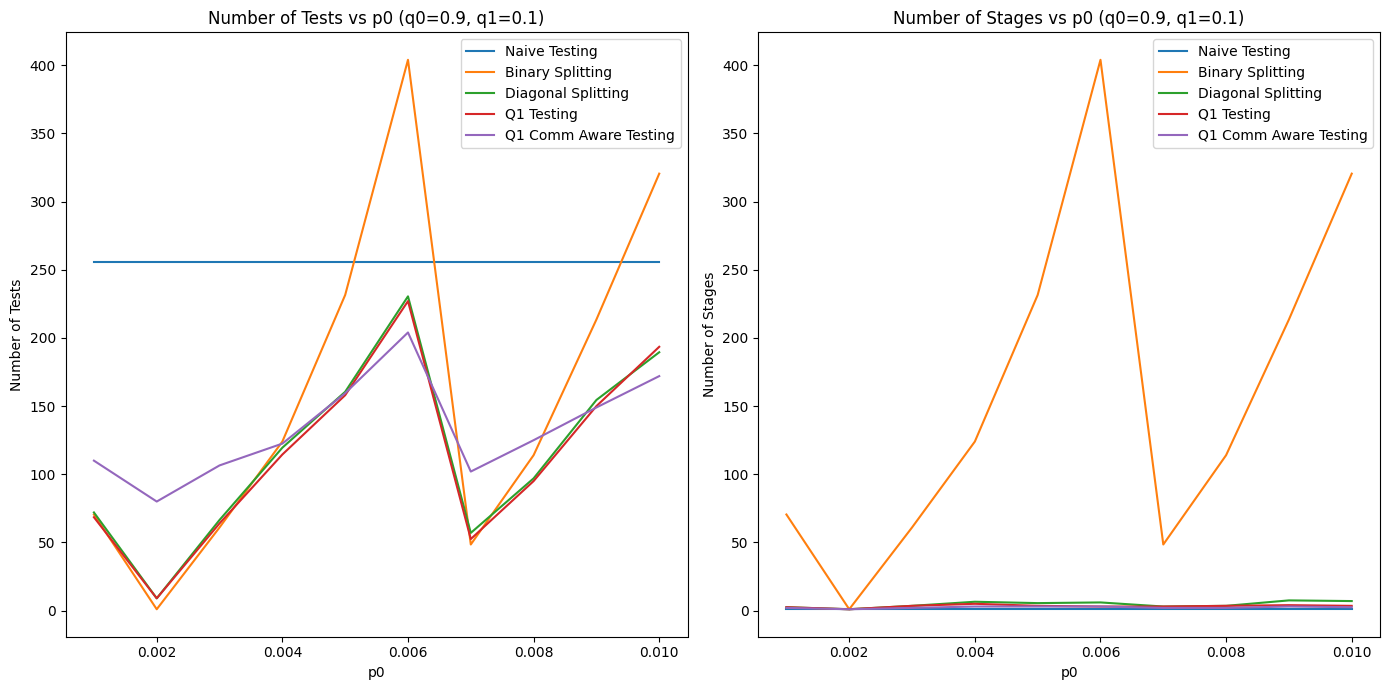

In [7]:
##################################
# this is when changing p0
##################################

# Set the parameters
N = 256
M = 16
p1 = 0.1
q0 = 0.9
q1 = 0.1
time_steps = 2
p0_values = np.arange(0.001, 0.011, 0.001)

# Initialize lists to store results
results = {"naive": [], "binary": [], "diag": [], "Q1": [], "Q1Comm": []}

# Run simulations
num_simulations = 2
for p0 in p0_values:
    naive_tests_total, naive_stages_total = 0, 0
    binary_tests_total, binary_stages_total = 0, 0
    diag_tests_total, diag_stages_total = 0, 0
    Q1_tests_total, Q1_stages_total = 0, 0
    Q1Comm_tests_total, Q1Comm_stages_total = 0, 0

    for _ in range(num_simulations):
        G = SBM(N, M, q0, q1)
        communities = create_communities(N, M)
        infection_progression = infect(G, p0, p1, time_steps)
        final_state = infection_progression

        naive_tests, naive_stages = naive_testing(final_state)[0:2]
        binary_tests, binary_stages = binary_splitting(final_state)[0:2]
        diag_tests, diag_stages = diag_splitting(final_state)
        Q1_tests, Q1_stages = Qtesting1(final_state)
        Q1Comm_tests, Q1Comm_stages = Qtesting1_comm_aware(final_state, communities)

        naive_tests_total += naive_tests
        naive_stages_total += naive_stages
        binary_tests_total += binary_tests
        binary_stages_total += binary_stages
        diag_tests_total += diag_tests
        diag_stages_total += diag_stages
        Q1_tests_total += Q1_tests
        Q1_stages_total += Q1_stages
        Q1Comm_tests_total += Q1Comm_tests
        Q1Comm_stages_total += Q1Comm_stages

    results["naive"].append((naive_tests_total / num_simulations, naive_stages_total / num_simulations))
    results["binary"].append((binary_tests_total / num_simulations, binary_stages_total / num_simulations))
    results["diag"].append((diag_tests_total / num_simulations, diag_stages_total / num_simulations))
    results["Q1"].append((Q1_tests_total / num_simulations, Q1_stages_total / num_simulations))
    results["Q1Comm"].append((Q1Comm_tests_total / num_simulations, Q1Comm_stages_total / num_simulations))

# Plotting the results
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(p0_values, [x[0] for x in results["naive"]], label='Naive Testing')
plt.plot(p0_values, [x[0] for x in results["binary"]], label='Binary Splitting')
plt.plot(p0_values, [x[0] for x in results["diag"]], label='Diagonal Splitting')
plt.plot(p0_values, [x[0] for x in results["Q1"]], label='Q1 Testing')
plt.plot(p0_values, [x[0] for x in results["Q1Comm"]], label='Q1 Comm Aware Testing')
plt.xlabel('p0')
plt.ylabel('Number of Tests')
plt.title(f'Number of Tests vs p0 (q0={q0}, q1={q1})')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(p0_values, [x[1] for x in results["naive"]], label='Naive Testing')
plt.plot(p0_values, [x[1] for x in results["binary"]], label='Binary Splitting')
plt.plot(p0_values, [x[1] for x in results["diag"]], label='Diagonal Splitting')
plt.plot(p0_values, [x[1] for x in results["Q1"]], label='Q1 Testing')
plt.plot(p0_values, [x[1] for x in results["Q1Comm"]], label='Q1 Comm Aware Testing')
plt.xlabel('p0')
plt.ylabel('Number of Stages')
plt.title(f'Number of Stages vs p0 (q0={q0}, q1={q1})')
plt.legend()

plt.tight_layout()
plt.show()


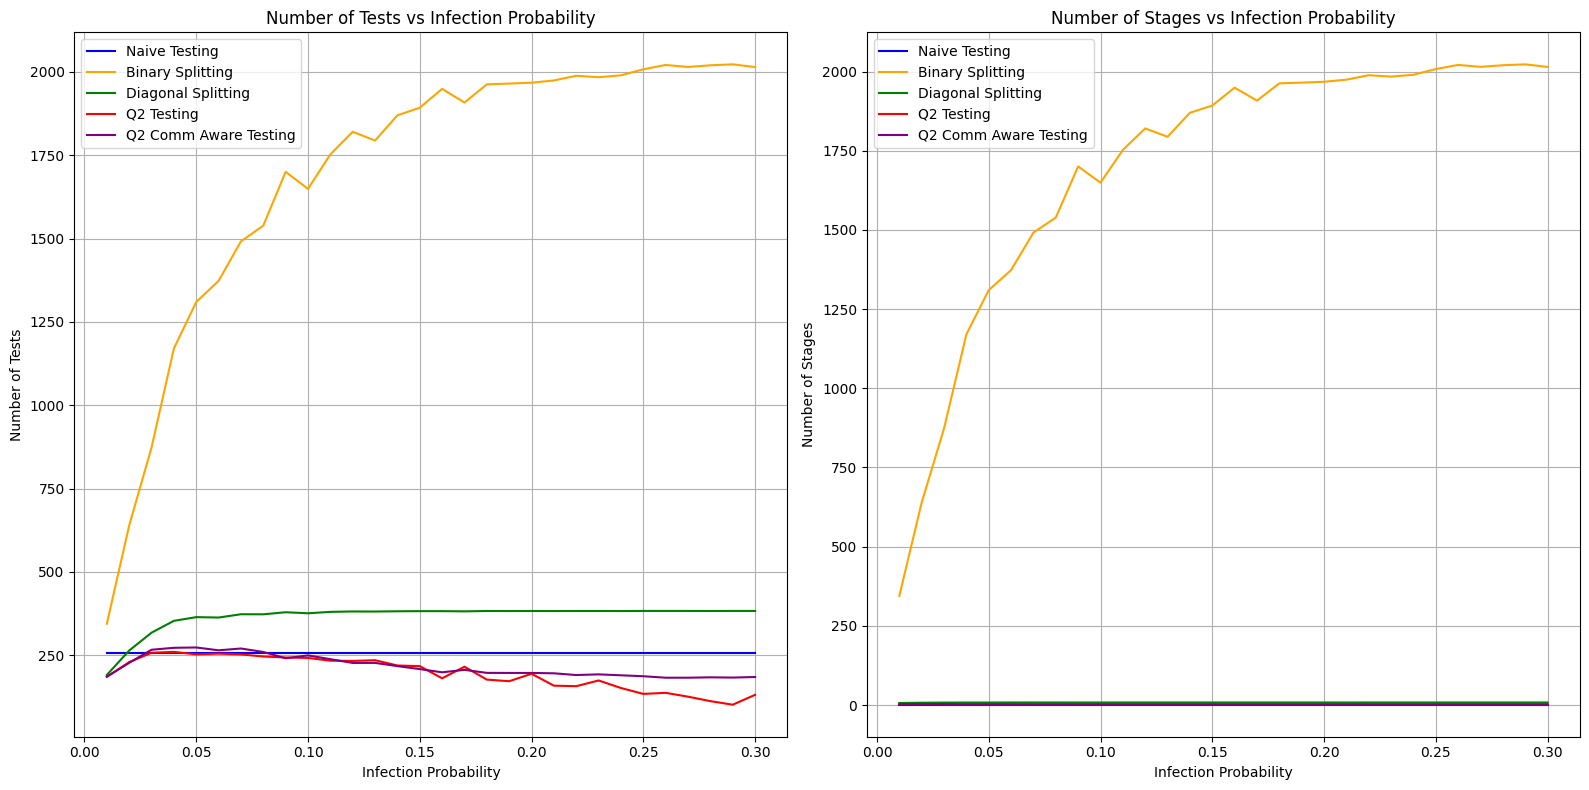

In [16]:
######################## Comparing Q2 and Q2 comm aware
# Initialize lists to store results
np.random.seed(50)

infection_probabilities = np.arange(0.01, 0.31, 0.01)
num_tests_naive = []
num_tests_binary = []
num_tests_diag = []
num_tests_q2 = []
num_tests_q2_comm = []
stages_naive = []
stages_binary = []
stages_diag = []
stages_q2 = []
stages_q2_comm = []

N = 256  # Total number of nodes
M = 16   # Number of communities
q0 = 0.9  # Intra-community connection probability
q1 = 0.1  # Inter-community connection probability
p1 = 0.1  # Probability of infection spread to neighbors
time_steps = 2  # Number of days to simulate the infection spread

# Run simulations for varying infection probabilities
for p0 in infection_probabilities:
    naive_tests_total, naive_stages_total = 0, 0
    binary_tests_total, binary_stages_total = 0, 0
    diag_tests_total, diag_stages_total = 0, 0
    Q2_tests_total, Q2_stages_total = 0, 0
    Q2Comm_tests_total, Q2Comm_stages_total = 0, 0

    for _ in range(10):  # Running multiple simulations
        G = SBM(N, M, q0, q1)
        communities = create_communities(N, M)
        infection_progression = infect(G, p0, p1, time_steps)
        final_state = infection_progression

        naive_tests, naive_stages = naive_testing(final_state)[0:2]
        binary_tests, binary_stages = binary_splitting(final_state)[0:2]
        diag_tests, diag_stages = diag_splitting(final_state)
        Q2_tests, Q2_stages = Qtesting2(final_state)
        Q2Comm_tests, Q2Comm_stages = Qtesting2_comm_aware(final_state, communities)

        naive_tests_total += naive_tests
        naive_stages_total += naive_stages
        binary_tests_total += binary_tests
        binary_stages_total += binary_stages
        diag_tests_total += diag_tests
        diag_stages_total += diag_stages
        Q2_tests_total += Q2_tests
        Q2_stages_total += Q2_stages
        Q2Comm_tests_total += Q2Comm_tests
        Q2Comm_stages_total += Q2Comm_stages

    num_tests_naive.append(naive_tests_total / 10)
    stages_naive.append(naive_stages_total / 10)
    num_tests_binary.append(binary_tests_total / 10)
    stages_binary.append(binary_stages_total / 10)
    num_tests_diag.append(diag_tests_total / 10)
    stages_diag.append(diag_stages_total / 10)
    num_tests_q2.append(Q2_tests_total / 10)
    stages_q2.append(Q2_stages_total / 10)
    num_tests_q2_comm.append(Q2Comm_tests_total / 10)
    stages_q2_comm.append(Q2Comm_stages_total / 10)

plt.figure(figsize=(16, 8))

# Plot Number of Tests
plt.subplot(1, 2, 1)
plt.plot(infection_probabilities, num_tests_naive, label="Naive Testing", color='blue')
plt.plot(infection_probabilities, num_tests_binary, label="Binary Splitting", color='orange')
plt.plot(infection_probabilities, num_tests_diag, label="Diagonal Splitting", color='green')
plt.plot(infection_probabilities, num_tests_q2, label="Q2 Testing", color='red')
plt.plot(infection_probabilities, num_tests_q2_comm, label="Q2 Comm Aware Testing", color='purple')

plt.xlabel("Infection Probability")
plt.ylabel("Number of Tests")
plt.title("Number of Tests vs Infection Probability")
plt.legend()
plt.grid(True)

# Plot Number of Stages
plt.subplot(1, 2, 2)
plt.plot(infection_probabilities, stages_naive, label="Naive Testing", color='blue')
plt.plot(infection_probabilities, stages_binary, label="Binary Splitting", color='orange')
plt.plot(infection_probabilities, stages_diag, label="Diagonal Splitting", color='green')
plt.plot(infection_probabilities, stages_q2, label="Q2 Testing", color='red')
plt.plot(infection_probabilities, stages_q2_comm, label="Q2 Comm Aware Testing", color='purple')

plt.xlabel("Infection Probability")
plt.ylabel("Number of Stages")
plt.title("Number of Stages vs Infection Probability")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


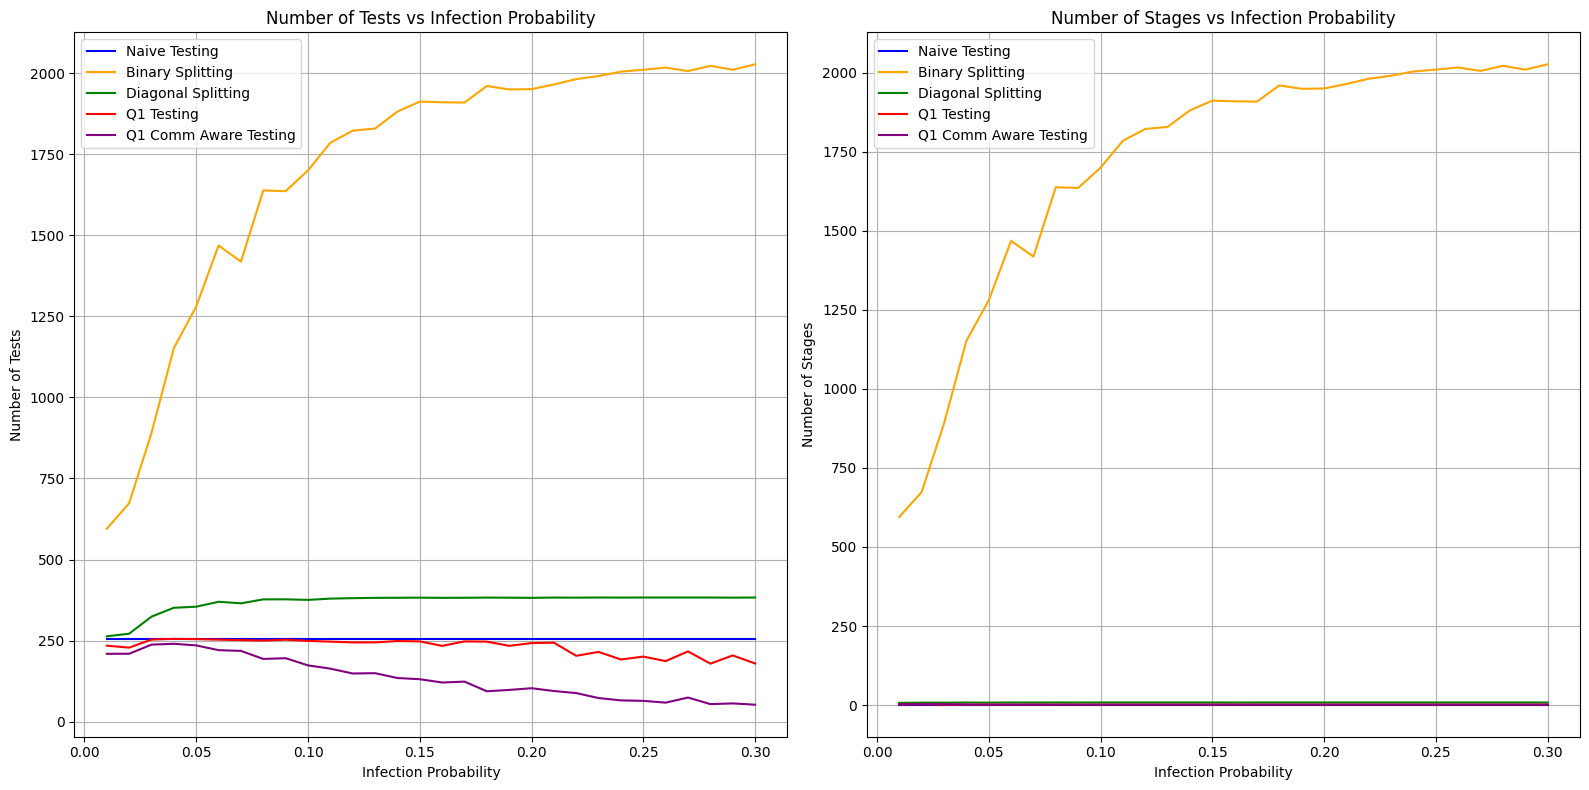

In [9]:
######################## Comparing Q1 and Q1 comm aware

# Initialize lists to store results
infection_probabilities = np.arange(0.01, 0.31, 0.01)
num_tests_naive = []
num_tests_binary = []
num_tests_diag = []
num_tests_q1 = []
num_tests_q1_comm = []
stages_naive = []
stages_binary = []
stages_diag = []
stages_q1 = []
stages_q1_comm = []

N = 256  # Total number of nodes
M = 16   # Number of communities
q0 = 0.9  # Intra-community connection probability
q1 = 0.1  # Inter-community connection probability
p1 = 0.1  # Probability of infection spread to neighbors
time_steps = 2  # Number of days to simulate the infection spread

# Run simulations for varying infection probabilities
for p0 in infection_probabilities:
    naive_tests_total, naive_stages_total = 0, 0
    binary_tests_total, binary_stages_total = 0, 0
    diag_tests_total, diag_stages_total = 0, 0
    Q1_tests_total, Q1_stages_total = 0, 0
    Q1Comm_tests_total, Q1Comm_stages_total = 0, 0

    for _ in range(10):  # Running multiple simulations
        G = SBM(N, M, q0, q1)
        communities = create_communities(N, M)
        infection_progression = infect(G, p0, p1, time_steps)
        final_state = infection_progression

        naive_tests, naive_stages = naive_testing(final_state)[0:2]
        binary_tests, binary_stages = binary_splitting(final_state)[0:2]
        diag_tests, diag_stages = diag_splitting(final_state)
        Q1_tests, Q1_stages = Qtesting1(final_state)
        Q1Comm_tests, Q1Comm_stages = Qtesting1_comm_aware(final_state, communities)

        naive_tests_total += naive_tests
        naive_stages_total += naive_stages
        binary_tests_total += binary_tests
        binary_stages_total += binary_stages
        diag_tests_total += diag_tests
        diag_stages_total += diag_stages
        Q1_tests_total += Q1_tests
        Q1_stages_total += Q1_stages
        Q1Comm_tests_total += Q1Comm_tests
        Q1Comm_stages_total += Q1Comm_stages

    num_tests_naive.append(naive_tests_total / 10)
    stages_naive.append(naive_stages_total / 10)
    num_tests_binary.append(binary_tests_total / 10)
    stages_binary.append(binary_stages_total / 10)
    num_tests_diag.append(diag_tests_total / 10)
    stages_diag.append(diag_stages_total / 10)
    num_tests_q1.append(Q1_tests_total / 10)
    stages_q1.append(Q1_stages_total / 10)
    num_tests_q1_comm.append(Q1Comm_tests_total / 10)
    stages_q1_comm.append(Q1Comm_stages_total / 10)

plt.figure(figsize=(16, 8))

# Plot Number of Tests
plt.subplot(1, 2, 1)
plt.plot(infection_probabilities, num_tests_naive, label="Naive Testing", color='blue')
plt.plot(infection_probabilities, num_tests_binary, label="Binary Splitting", color='orange')
plt.plot(infection_probabilities, num_tests_diag, label="Diagonal Splitting", color='green')
plt.plot(infection_probabilities, num_tests_q1, label="Q1 Testing", color='red')
plt.plot(infection_probabilities, num_tests_q1_comm, label="Q1 Comm Aware Testing", color='purple')

plt.xlabel("Infection Probability")
plt.ylabel("Number of Tests")
plt.title("Number of Tests vs Infection Probability")
plt.legend()
plt.grid(True)

# Plot Number of Stages
plt.subplot(1, 2, 2)
plt.plot(infection_probabilities, stages_naive, label="Naive Testing", color='blue')
plt.plot(infection_probabilities, stages_binary, label="Binary Splitting", color='orange')
plt.plot(infection_probabilities, stages_diag, label="Diagonal Splitting", color='green')
plt.plot(infection_probabilities, stages_q1, label="Q1 Testing", color='red')
plt.plot(infection_probabilities, stages_q1_comm, label="Q1 Comm Aware Testing", color='purple')

plt.xlabel("Infection Probability")
plt.ylabel("Number of Stages")
plt.title("Number of Stages vs Infection Probability")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [10]:
def iter(N,M,q0,q1,p0,p1,time_steps,num_sims,method,dataset='sbm'):

    name = dataset+'N'+str(N)+'_M'+str(M)+'_SIM'+str(num_sims)+'_step'+str(time_steps)+'_q0'+str(q0)+'_q1'+str(q1)+'_p0'+str(p0)+'_p1'+str(p1)+method+'graphs.pkl'
    if not os.path.isfile(name):
        print('Generating synthetic dataset!')
        Gs = np.zeros((num_sims,N,N))
        Communities = dict()
        data = dict()
        Individuals = dict()
        if dataset=='sbm':
            for i in range(num_sims):
                Gs[i] = SBM(N,M,q0,q1)
                ###################################################
                '''your code here'''
                communities = []
                ###################################################
                Communities[i] = communities
                Individuals[i] = infect(Gs[i],p0,p1,time_steps)
        elif dataset=='iid':
            for i in range(num_sims):
                ###################################################
                '''your code here'''
                # Individuals[i] = 
                # Communities[i] =[[all individuals]]
                ###################################################
        data['graph'] = Gs
        data['communities'] = Communities
        data['individuals'] = Individuals
        with open(name, 'wb') as infile:
            pickle.dump(data,infile) 
    #         print('Dataset done!')


    ###################################################
    '''your code for initialization parameters if needed''' 
    fraction_ppl = 0
    fraction_family = 0
    fraction_ppl_in_family = 0
    #num_tests = 
    #num_stages = 
    ###################################################
        
    if os.path.isfile(name):
        with open(name, 'rb') as infile:
            data = pickle.load(infile) 
        print('Data loaded!')
    for i in range(num_sims):
        if dataset=='synthetic':
            G = data['graph'][i]
            communities = data['communities'][i]
            individuals = data['individuals'][i]
        ###################################################
        '''your code to calculate the statistics here''' 

        
        ###################################################

        # interleave the individuals
        s = individuals.copy()
        np.random.shuffle(s)
        # binary
        numtests_bs, num_stages_bs, _ = binary_splitting(s)
        # algorithm 1
        numtests_q1, num_stages_q1 = Qtesting1(s)
        # algorithm 2
        numtests_q2, num_stages_q2 = Qtesting2(s)
        # community-aware
        numtests_q1_c, num_stages_q1_c = Qtesting1_comm_aware(individuals.copy(),communities)
        # community-aware
        numtests_q2_c, num_stages_q2_c = Qtesting2_comm_aware(individuals.copy(),communities)

    ###################################################
    '''your code to calculate the statistics here''' 
    '''Do not forget to take the average'''

    ###################################################
            

    return fraction_ppl, fraction_family, fraction_ppl_in_family, num_tests, num_stages

<div class="alert alert-warning">
<b>Task 1 </b> 
Plot how the fraction of infected people, the percentage of infected communities, and the average percentage of infected people in each community change with the each setting for the synthetic dataset described in the following table and comment on the results. Average over at least $100$ SBM network realization.     

</div>

| N | M | q0, q1 | p0 | p1 |time steps  |
|---|---|--------|----|----|------------|
|256| 16| (1,0)  |0.001|[0.05:1]|2|
|   | 16|(0.9, 0.1)  | 0.001| [0.05:1]|2     |
|   | 16 |(0.5, 0.2)  | 0.001| [0.05:1]|2     |

Consider $N=256$, and $M=16,64,128$. Use SBM with $q0=1$ and $q1=0$ to generate contact networks (disconnected cliques). For the infection model, use $p_0 = 0.001$ and $p_1 = [0.01:1]$ and the number of infection steps as $2$ . 
Average over 100 SBM network realizations.

<div class="alert alert-warning">
<b>Task 2 </b> 
Provide plots for i.i.d. infection probability that ranges from $p=0.01$ to $p=0.3$, and $N=256$.
Compare the performance of tests $T_1$, $T_2$, and binary output tests. Do you observe a consistent performance? Can you explain your results? 
    
</div>

<div class="alert alert-warning">
<b>Task 3 </b>  
Provide plots that compare the performance of various testing techniques on the Stochastic Block Model (SBM) using the settings outlined in Table 2 and on real data. You may explore additional settings that could reveal significant insights for your custom algorithms. Interpret and explain the results you obtain. Your plots should include: (i) a plot demonstrating how the performance of different testing schemes varies as the family sizes change, (ii)a plot demonstrating how the performance of different testing schemes varies as the infection probability changes and (iii) a plot illustrating how infections concentrate within families in the SBM.
</div>

| N | M | q0, q1 | p0 | p1 |time steps  |
|---|---|--------|----|----|------------|
|256| 16| (0.9,0.1)  |0.001|[0.05:1]|2|
|   | 64|(1, 0)  | 0.001| [0.05:1]|2     |
|   | 64|(0.9, 0.1)  | 0.001| [0.05:1]|2     |
|   | 64|(0.5, 0.2)  | 0.001| [0.05:1]|2     |
|   | 128 |(0.9, 0.1)  | 0.001| [0.05:1]|2     |


In [11]:
N = 256
M = 16
q0 = 0.5
q1 = 0.3

time_steps = 2
method = 'your method'

In [12]:
# the simulation 
t = 10
fraction_infected_ppl = np.zeros(t)
fraction_infected_clc = np.zeros(t)
fraction_infected_family = np.zeros(t)
num_tests = np.zeros((t,3))
num_stages = np.zeros((t,3))
p0 = 0.001
num_sims = 100
for j in range(1,t+1):
    p1 = j/t
    fraction_ppl[j-1], fraction_clc[j-1], fraction_plp_in_clc[j-1], num_tests[j-1], num_stages[j-1]= iter(N,M,q0,q1,p0,p1,time_steps,num_sims,method,dataset='sbm')  
       

Data loaded!


UnboundLocalError: cannot access local variable 'individuals' where it is not associated with a value

In [ ]:
p1s = np.arange(1,t+1)/t

In [ ]:
plt.figure(figsize=(6, 4), dpi=300)
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'sans-serif',
    'font.sans-serif': 'Arial',
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})
markers = ['.', ',','o','v','^','<','>']
   
plt.plot(p1s,num_tests[:,i],label='binary splitting',marker=markers[i])
#########your code here###########

plt.xlabel('Transmission probability: p1',fontsize=14)
plt.ylabel('Expected number of tests',fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.legend(frameon=False, loc='best')
plt.tight_layout()
fig_name = 'RES_N'+str(N)+'_M'+str(M)+'SIM'+str(num_sims)+'step_'+str(time_steps)+'q0'+str(q0)+'q1'+str(q1)+'p0'+str(p0)+method+'GT.pdf'
plt.savefig(fig_name, format='pdf', bbox_inches='tight')

In [ ]:
plt.plot(p1s,fraction_ppl,label='Fraction of infected people')
plt.plot(p1s,fraction_clc,label='Fraction of infected communities')
plt.plot(p1s,fraction_plp_in_clc,label='Fraction of infected people in each community')
plt.xlabel('Transmission probability: p1',fontsize=14)
plt.ylabel('Infection stats',fontsize=14)
plt.legend()
plt.savefig('RES_N'+str(N)+'_M'+str(M)+'SIM'+str(num_sims)+'step_'+str(time_steps)+'q0'+str(q0)+'q1'+str(q1)+'p0'+str(p0)+method+'stats.pdf')